# Image Models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](ここに以下の書式でURLを入れる) 
[![github](https://badgen.net/badge/:status/View%20On%20Github/black?icon=github&label)](https://github.com/AtomScott/SoccerTrack)
[![badge](https://img.shields.io/badge/launch-binder-579ACA.svg?logo=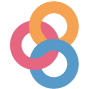)](https://)

---

In [1]:
%load_ext autoreload
%autoreload 2

Image embeddings are a critical component in the field of Multiple Object Tracking (MOT). These embeddings are essentially vector representations of images, encapsulating various visual features. The process of generating image embeddings often involves the use of Convolutional Neural Networks (CNNs) or pre-trained models such as ResNet and VGG. These models are particularly effective in tasks such as image classification, object detection, and determining image similarity.

![Extraction Gif](./assets/image_model_extraction.gif)

## Load an image model

`SportsLabKit` has many models available for use.Use the following code to show models that are currently available:

In [2]:
import sportslabkit as slk

slk.image_model.show_available_models()

['BaseCLIP',
 'BaseTorchReIDModel',
 'CLIP_RN101',
 'CLIP_RN50',
 'CLIP_RN50x16',
 'CLIP_RN50x4',
 'CLIP_RN50x64',
 'CLIP_ViT_B_16',
 'CLIP_ViT_B_32',
 'CLIP_ViT_L_14',
 'CLIP_ViT_L_14_336px',
 'MLFN',
 'MobileNetV2_x1_0',
 'MobileNetV2_x1_4',
 'OSNet_ain_x0_25',
 'OSNet_ain_x0_5',
 'OSNet_ain_x0_75',
 'OSNet_ain_x1_0',
 'OSNet_ibn_x1_0',
 'OSNet_x0_25',
 'OSNet_x0_5',
 'OSNet_x0_75',
 'OSNet_x1_0',
 'ResNet50',
 'ResNet50_fc512',
 'ShuffleNet']

You can see that in the above there are models such as `ResNet50`, `OSNet` and `CLIP`.


* `ResNet50` - ResNet50 is a variant of ResNet model, which is a convolutional neural network that is 50 layers deep. It's a widely used model for image classification tasks.

* `OSNet` - OSNet (Omni-Scale Network) is a lightweight model designed for person re-identification tasks. It is capable of capturing features at multiple scales and is highly efficient.

* `CLIP` - Contrary to traditional models, CLIP (Contrastive Language–Image Pretraining) is trained on a large number of images and their associated text data. It is designed to understand and generate a wide range of natural language descriptions from images.

Now, let's load a dataset and start working with these models. First, lets start with `ResNet50` as it is a well known CNN for handling images.

### Load ResNet50 with default settings

You can load a model by using the `load` function. The function searches subclasses of `BaseImageModel` for a match with the given name. If a match is found, an instance of the model is returned. If no match is found, a warning is logged and the function returns None. 

In [3]:
resnet = slk.image_model.load("resnet50")

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


### Load ResNet50 with custom configuration

All models that inherit from `BaseImageModel` class have two configuration dictionaries that can be passed as arguments to `load()`.

* `model_config` - Configuration for parameters that are set at instantiation.
* `inference_config` - Configuation for parameters that are used at inference.

> *Note.* The distinction between the two configs are somewhat blurry and so the API may be subject to change in upcoming versions. For now, use the `show_model_config()` and `show_inference_config()` methods to find out what parameters are a available.

In [4]:
resnet.show_model_config()
resnet.show_inference_config()

show_model_config:0210  💬| Model configuration: 
show_model_config:0212  💬|   name: resnet50 
show_model_config:0212  💬|   path: https://drive.google.com/file/d/1ep7RypVDOthCRIAqDnn4_N-UhkkFHJsj/view?usp=sharing 
show_model_config:0212  💬|   device: cpu 
show_model_config:0212  💬|   image_size: (256, 128) 
show_model_config:0212  💬|   pixel_mean: [0.485, 0.456, 0.406] 
show_model_config:0212  💬|   pixel_std: [0.229, 0.224, 0.225] 
show_model_config:0212  💬|   pixel_norm: True 
show_model_config:0212  💬|   verbose: False 
show_inference_config:0215  💬| Inference configuration: 


As you can see, there are many parameters we can configure. Let's set the configuration so that images are smaller.

In [5]:
model_config = {"image_size": (32, 32)}
resnet = slk.image_model.load("resnet50", model_config=model_config)

## Inference with an Image Model

The input to the model should be flexible. It accepts numpy.ndarray, torch.Tensor, pathlib Path, string file, PIL Image, or a list of any of these. All inputs will be converted to a list of numpy arrays representing the images.

The output of the model is expected to be a two dimensional numpy array. The first dimension is the number of images in the input. The second dimension is the number of features in the embedding.

In [6]:
# First prepare the dataset:
dataset_path = slk.datasets.get_path("wide_view")
path_to_csv = sorted(dataset_path.glob("annotations/*.csv"))[0]
path_to_mp4 = sorted(dataset_path.glob("videos/*.mp4"))[0]

# Image as input
cam = slk.Camera(path_to_mp4)
frame = cam.get_frame(0)
print(resnet(frame).shape)

(1, 2048)


## Inference with an Image Model (batched input)

In [7]:
print(resnet([frame, frame, frame, frame]).shape)

(4, 2048)


## Extract features from a bbox

One common use case for image embedding in tracking is to extract image features from a detected bounding box. The `Detection` object is a simple class that contains a bounding box and an image. The `Detection` object can be used as input to the `embed_detections` function.

In [8]:
det_model = slk.detection_model.load(model_name="yolov8s")
detections = det_model(frame, imgsz=960)[0]

embeddings = resnet.embed_detections(detections, frame)

print(detections.to_df())
print(embeddings.shape)

     bbox_left    bbox_top  bbox_width  bbox_height      conf  class
0  3467.539429  803.042358    54.41626     91.78064  0.333656    0.0
(1, 2048)


## Use embeddings to perform classification

Another common use case for embeddings is to perform classification. First, download the dataset from [here](https://drive.google.com/file/d/1XRt1GBVPEDlkygtqJ9NP4B6z7FjE4yg7/view?usp=share_link). After extracting the dataset you can use the code below to load the dataset.

In [9]:
from pathlib import Path
from tqdm import tqdm
import numpy as np

N = 500
dataset_root = slk.utils.get_git_root() / "data" / "image_model_dataset"
_train_image_paths = sorted((dataset_root / "trainset").glob("**/*.png"))
np.random.shuffle(_train_image_paths)
train_image_paths = [str(p) for p in _train_image_paths[:N]]
train_labels = np.array([int(p.parent.name) for p in _train_image_paths[:N]])

_test_image_paths = sorted((dataset_root / "testset").glob("**/*.png"))
np.random.shuffle(_test_image_paths)
test_image_paths = [str(p) for p in _test_image_paths[:N]]
test_labels = np.array([int(p.parent.name) for p in _test_image_paths[:N]])

print(f"n_train_images: {len(train_image_paths)}")
print(f"n_test_images: {len(test_image_paths)}")

n_train_images: 500
n_test_images: 500


In [10]:
import numpy as np
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

def extract_features(image_model, image_paths, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch = image_paths[i:i+batch_size]
        embeddings += [x for x in image_model(batch)]
    return np.array(embeddings).squeeze()

model_embeddings = {} # Lets cache the embeddings so we don't have to recompute them
for model_name in ["resnet50", "OSNet_x1_0", "CLIP_RN50"]:
    image_model = slk.image_model.load(model_name, model_config={"image_size": (128, 128)})

    train_embeddings = extract_features(image_model, train_image_paths)
    test_embeddings = extract_features(image_model, test_image_paths)

    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(train_embeddings, train_labels)

    score = clf.score(test_embeddings, test_labels)
    print(f"{model_name}: {score}")

    model_embeddings[model_name] = np.concatenate([train_embeddings, test_embeddings])

100%|██████████| 16/16 [00:24<00:00,  1.50s/it]


resnet50: 0.99


100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


OSNet_x1_0: 0.99


100%|██████████| 16/16 [01:36<00:00,  6.06s/it]


CLIP_RN50: 0.996


## Visualize Embeddings with t-SNE

We can also plot the t-SNE embeddings with the ground truth labels and color by team. `SportsLabKit` has a visualization function `plot_tsne` built in.

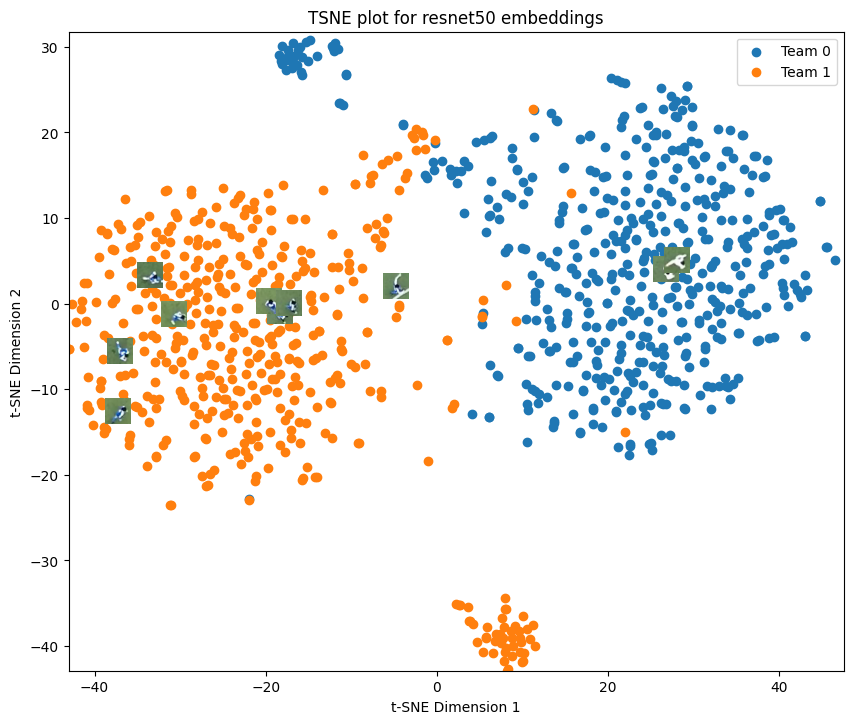

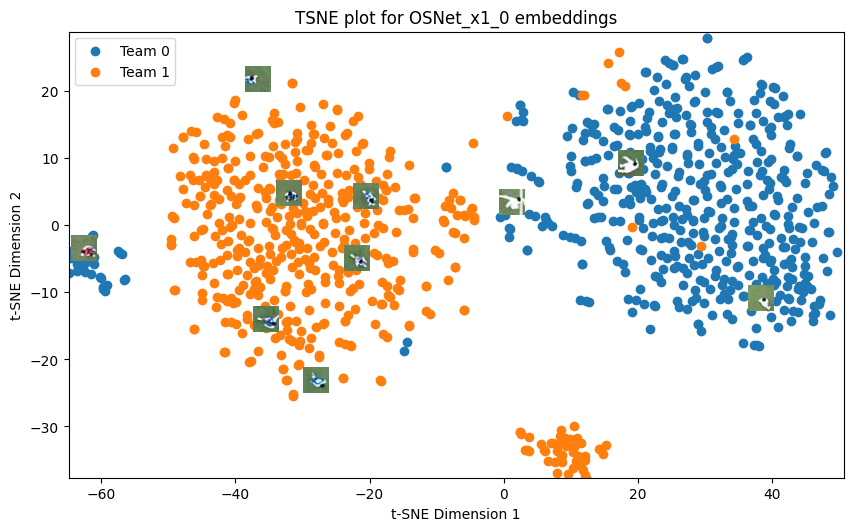

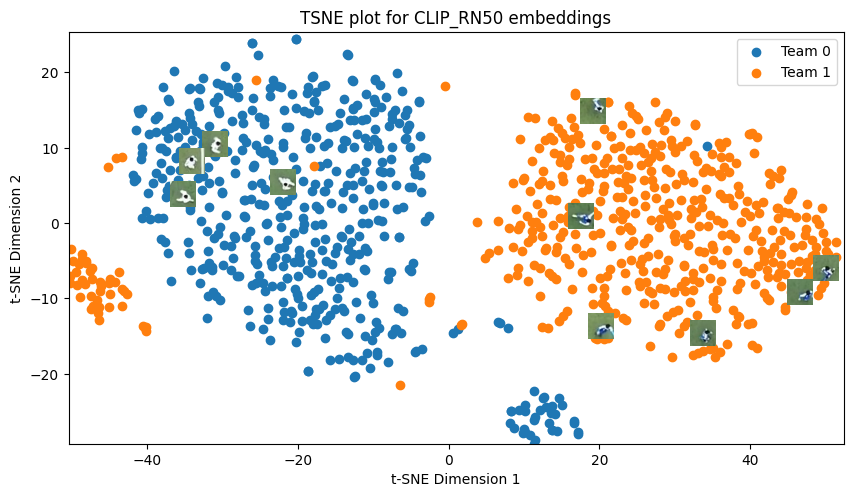

In [11]:
from sportslabkit.image_model import plot_tsne

for model_name in ["resnet50", "OSNet_x1_0", "CLIP_RN50"]:
    embeddings = model_embeddings[model_name]
    plot_tsne(embeddings, np.concatenate((train_labels,test_labels)), train_image_paths + test_image_paths, title=f"TSNE plot for {model_name} embeddings")